# "Corona visualizations"
> "Awesome summary"
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
%config InlineBackend.figure_format = 'retina'

chart_width = 850
chart_height= 400

# source: https://colab.research.google.com/github/github/covid19-dashboard/blob/master/_notebooks/2020-03-19-cases-and-deaths-per-million.ipynb

## Data loading

In [2]:
countries = ["China", "Italy", "Spain", "France", "United Kingdom", "Germany", 
             "United States","South Korea", "Japan"]

In [3]:
#hide 
data = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv", error_bad_lines=False)
data = data.drop(columns=["Lat", "Long"])
data = data.melt(id_vars= ["Province/State", "Country/Region"])
data = pd.DataFrame(data.groupby(['Country/Region', "variable"]).sum())
data.reset_index(inplace=True)  
data = data.rename(columns={"Country/Region": "location", "variable": "date", "value": "total_cases"})
data['date'] =pd.to_datetime(data.date)
data = data.sort_values(by = "date")
data.loc[data.location == "US","location"] = "United States"
data.loc[data.location == "Korea, South","location"] = "South Korea"

data_pwt = pd.read_stata("https://www.rug.nl/ggdc/docs/pwt91.dta")

filter1 = data_pwt["year"] == 2017
data_pop = data_pwt[filter1]
data_pop = data_pop[["country","pop"]]
data_pop.loc[data_pop.country == "Republic of Korea","country"] = "South Korea"
data_pop.loc[data_pop.country == "Iran (Islamic Republic of)","country"] = "Iran"

# per habitant
data_pc = data.copy()
# countries = ["China", "Italy", "Spain", "France", "United Kingdom", "Germany", 
#              "Portugal", "United States", "Singapore","South Korea", "Japan", 
#              "Brazil","Iran"]

data_countries = []
data_countries_pc = []

# compute per habitant
for i in countries:
    data_pc.loc[data_pc.location == i,"total_cases"] = data_pc.loc[data_pc.location == i,"total_cases"]/float(data_pop.loc[data_pop.country == i, "pop"])

    # get each country time series
filter1 = data_pc["total_cases"] > 1
for i in countries:
    filter_country = data_pc["location"]== i
    data_countries_pc.append(data_pc[filter_country & filter1])

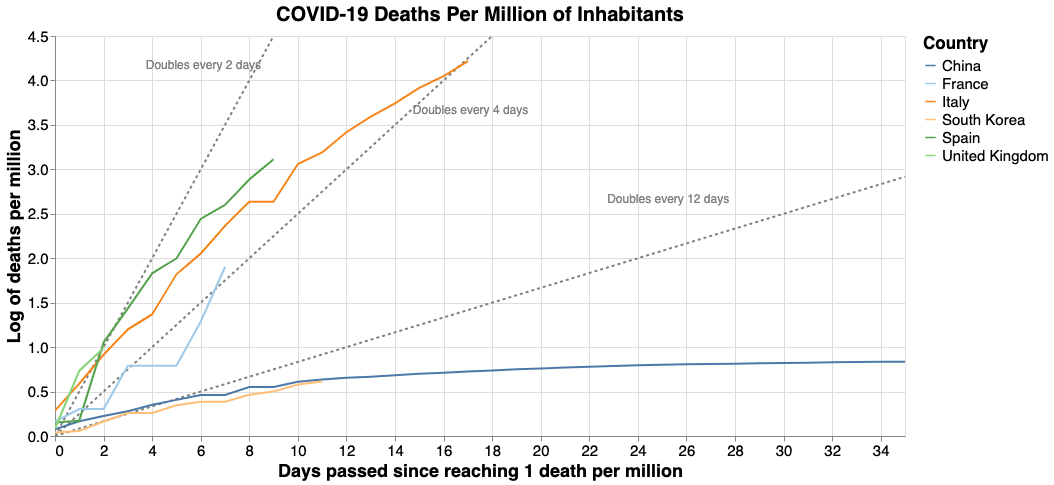

In [4]:
#hide_input
# Stack data to get it to Altair dataframe format
data_countries_pc2 = data_countries_pc.copy()
for i in range(0,len(countries)):
    data_countries_pc2[i] = data_countries_pc2[i].reset_index()
    data_countries_pc2[i]['n_days'] = data_countries_pc2[i].index
    data_countries_pc2[i]['log_cases'] = np.log(data_countries_pc2[i]["total_cases"])
data_plot = data_countries_pc2[0]
for i in range(1, len(countries)):    
    data_plot = pd.concat([data_plot, data_countries_pc2[i]], axis=0)
data_plot["trend_2days"] = data_plot["n_days"]*1/2
data_plot["trend_4days"] = data_plot["n_days"]*1/4
data_plot["trend_12days"] = data_plot["n_days"]*1/12
data_plot["trend_2days_label"] = "Doubles every 2 days"
data_plot["trend_4days_label"] = "Doubles evey 4 days"
data_plot["trend_12days_label"] = "Doubles every 12 days"


# Plot it using Altair
source = data_plot

scales = alt.selection_interval(bind='scales')
#selection = alt.selection_multi(fields=['location'], bind='legend')

base = alt.Chart(source, title = "COVID-19 Deaths Per Million of Inhabitants").encode(
    x = alt.X('n_days:Q', title = "Days passed since reaching 1 death per million"),
    y = alt.Y("log_cases:Q",title = "Log of deaths per million"),
    color = alt.Color('location:N', legend=alt.Legend(title="Country", labelFontSize=15, titleFontSize=17),
                     scale=alt.Scale(scheme='tableau20')),
    #opacity = alt.condition(selection, alt.value(1), alt.value(0.1))
)

lines = base.mark_line().add_selection(
    scales
).properties(
   width=chart_width,
   height=chart_height
)
#.add_selection(
#    selection
#)

trend_2d = alt.Chart(source).encode(
    x = "n_days:Q",
    y = alt.Y("trend_2days:Q",  scale=alt.Scale(domain=(0, max(data_plot["log_cases"])))),
).mark_line(color="grey", strokeDash=[3,3])


labels = pd.DataFrame([{'label': 'Doubles every 2 days', 'x_coord': 6, 'y_coord': 4},
                       {'label': 'Doubles every 4 days', 'x_coord': 17, 'y_coord': 3.5},
                       {'label': 'Doubles every 12 days', 'x_coord': 25, 'y_coord': 2.5},
                      ])
trend_label = (alt.Chart(labels)
                    .mark_text(align='left', dx=-55, dy=-15, fontSize=12, color="grey")
                    .encode(x='x_coord:Q',
                            y='y_coord:Q',
                            text='label:N')
                   )

trend_4d = alt.Chart(source).mark_line(color="grey", strokeDash=[3,3]).encode(
    x = "n_days:Q",
    y = alt.Y("trend_4days:Q",  scale=alt.Scale(domain=(0, max(data_plot["log_cases"])))),
)

trend_12d = alt.Chart(source).mark_line(color="grey", strokeDash=[3,3]).encode(
    x = "n_days:Q",
    y = alt.Y("trend_12days:Q",  scale=alt.Scale(domain=(0, max(data_plot["log_cases"])))),
)


(
(trend_2d + trend_4d + trend_12d + trend_label + lines)
.configure_title(fontSize=20)
.configure_axis(labelFontSize=15,titleFontSize=18)
)

In [5]:
#hide_input
label = 'Deaths'
temp = pd.concat([x.copy() for x in data_countries_pc]).loc[lambda x: x.date >= '3/1/2020']

metric_name = f'{label} per Million'
temp.columns = ['Country', 'date', metric_name]
# temp.loc[:, 'month'] = temp.date.dt.strftime('%Y-%m')
temp.loc[:, f'Log of {label} per Million'] = temp[f'{label} per Million'].apply(lambda x: np.log(x))

temp.groupby('Country').last()

,date,Deaths per Million,Log of Deaths per Million
Country,,,
China,2020-03-20,2.307882,0.836330
France,2020-03-20,6.693804,1.901182
Italy,2020-03-20,67.924641,4.218399
South Korea,2020-03-20,1.843780,0.611818
Spain,2020-03-20,22.500599,3.113542
United Kingdom,2020-03-20,2.689570,0.989381


In [6]:
#hide
# Get data and clean it

data = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv", error_bad_lines=False)
data = data.drop(columns=["Lat", "Long"])
data = data.melt(id_vars= ["Province/State", "Country/Region"])
data = pd.DataFrame(data.groupby(['Country/Region', "variable"]).sum())
data.reset_index(inplace=True)  
data = data.rename(columns={"Country/Region": "location", "variable": "date", "value": "total_cases"})
data['date'] =pd.to_datetime(data.date)
data = data.sort_values(by = "date")
data.loc[data.location == "US","location"] = "United States"
data.loc[data.location == "Korea, South","location"] = "South Korea"

# Population data (last year is 2017 which is what we use)
data_pwt = pd.read_stata("https://www.rug.nl/ggdc/docs/pwt91.dta")

filter1 = data_pwt["year"] == 2017
data_pop = data_pwt[filter1]
data_pop = data_pop[["country","pop"]]
data_pop.loc[data_pop.country == "Republic of Korea","country"] = "South Korea"
data_pop.loc[data_pop.country == "Iran (Islamic Republic of)","country"] = "Iran"

# per habitant
data_pc = data.copy()

# I can add more countries if needed

data_countries = []
data_countries_pc = []

# compute per habitant
for i in countries:
    data_pc.loc[data_pc.location == i,"total_cases"] = data_pc.loc[data_pc.location == i,"total_cases"]/float(data_pop.loc[data_pop.country == i, "pop"])
    
# get each country time series
filter1 = data_pc["total_cases"] > 1

for i in countries:
    filter_country = data_pc["location"]== i
    data_countries_pc.append(data_pc[filter_country & filter1])

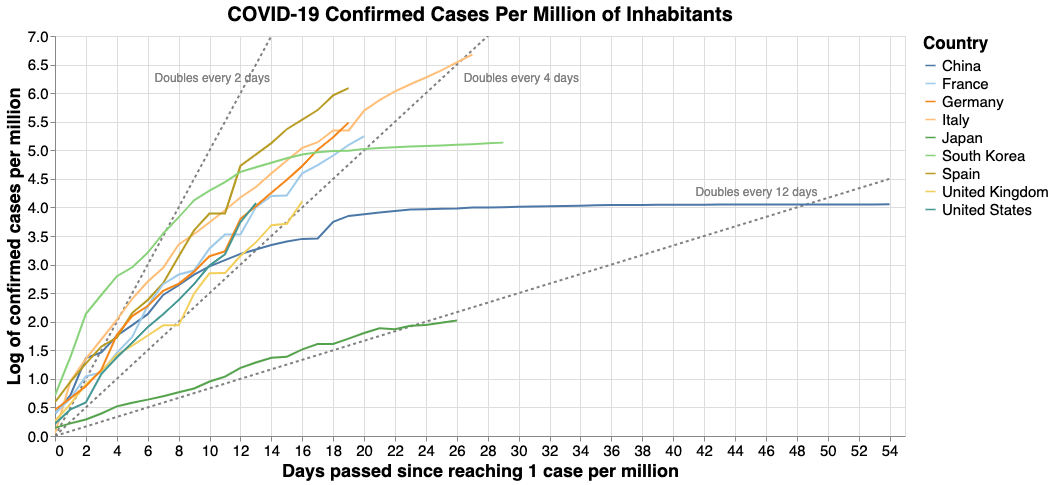

In [7]:
#hide_input
# Stack data to get it to Altair dataframe format
data_countries_pc2 = data_countries_pc.copy()
for i in range(0,len(countries)):
    data_countries_pc2[i] = data_countries_pc2[i].reset_index()
    data_countries_pc2[i]['n_days'] = data_countries_pc2[i].index
    data_countries_pc2[i]['log_cases'] = np.log(data_countries_pc2[i]["total_cases"])
data_plot = data_countries_pc2[0]
for i in range(1, len(countries)):    
    data_plot = pd.concat([data_plot, data_countries_pc2[i]], axis=0)
data_plot["trend_2days"] = data_plot["n_days"]*1/2
data_plot["trend_4days"] = data_plot["n_days"]*1/4
data_plot["trend_12days"] = data_plot["n_days"]*1/12
data_plot["trend_2days_label"] = "Doubles every 2 days"
data_plot["trend_4days_label"] = "Doubles evey 4 days"
data_plot["trend_12days_label"] = "Doubles every 12 days"


# Plot it using Altair
source = data_plot

scales = alt.selection_interval(bind='scales')
#selection = alt.selection_multi(fields=['location'], bind='legend')

base = alt.Chart(source, title = "COVID-19 Confirmed Cases Per Million of Inhabitants").encode(
    x = alt.X('n_days:Q', title = "Days passed since reaching 1 case per million"),
    y = alt.Y("log_cases:Q",title = "Log of confirmed cases per million"),
    color = alt.Color('location:N', legend=alt.Legend(title="Country", labelFontSize=15, titleFontSize=17),
                     scale=alt.Scale(scheme='tableau20')),
    #opacity = alt.condition(selection, alt.value(1), alt.value(0.1))
).properties(
    width=chart_width,
    height=chart_height
)

lines = base.mark_line().add_selection(
    scales
)
# .add_selection(
#     selection
# )

trend_2d = alt.Chart(source).encode(
    x = "n_days:Q",
    y = alt.Y("trend_2days:Q",  scale=alt.Scale(domain=(0, max(data_plot["log_cases"])))),
).mark_line( strokeDash=[3,3], color="grey")

labels = pd.DataFrame([{'label': 'Doubles every 2 days', 'x_coord': 10, 'y_coord': 6},
                       {'label': 'Doubles every 4 days', 'x_coord': 30, 'y_coord': 6},
                       {'label': 'Doubles every 12 days', 'x_coord': 45, 'y_coord': 4},
                      ])
trend_label = (alt.Chart(labels)
                    .mark_text(align='left', dx=-55, dy=-15, fontSize=12, color="grey")
                    .encode(x='x_coord:Q',
                            y='y_coord:Q',
                            text='label:N')
                   )


trend_4d = alt.Chart(source).mark_line(color="grey", strokeDash=[3,3]).encode(
    x = "n_days:Q",
    y = alt.Y("trend_4days:Q",  scale=alt.Scale(domain=(0, max(data_plot["log_cases"])))),
)

trend_12d = alt.Chart(source).mark_line(color="grey", strokeDash=[3,3]).encode(
    x = "n_days:Q",
    y = alt.Y("trend_12days:Q",  scale=alt.Scale(domain=(0, max(data_plot["log_cases"])))),
)

(
(trend_2d  + trend_4d + trend_12d + trend_label + lines)
.configure_title(fontSize=20)
.configure_axis(labelFontSize=15,titleFontSize=18)
)